# Installs

In [1]:
!pip install classiq #Install classiq in case you don't have it in the environment already

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.0
    Uninstalling sympy-1.13.0:
      Successfu

# Imports

In [12]:
from classiq import *
import matplotlib.pyplot as plt
import numpy as np

# Code

In [3]:
authenticate() #Remember to authenticate before executing the code to be aviable the synthetize function

Your user code: FPKJ-LWRQ
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=FPKJ-LWRQ


Most of the code is based on  the code from class: https://github.com/Classiq/classiq-library/blob/main/community/womanium/assignments/quantum_walk_circle_example.py. The code has been adapted to instead of making a closed chain of nodes, to make a circuit to represent an open chain nodes.

In [8]:
size = 4 #Number of qubits used to represent the nodes (for 16 nodes: 2**4=16)

#Function that preparates the |-> state
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)

#Function that implements the diffuser for Grover's algorithm
@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
  aux ^= (x != 0)

#Function that makes the zero diffuser for the quantum walk
@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

Until here, is the same code for the closed chain. But as now are using a chain with CC conditions (the extreme nodes are only connected to one neighbour) we have to make a little change on the "W_iteration()" code function. Now the probability of the walker being in an extreme node (in this case at Node 0 or Node 15) to move from these node to its neighbour is always 1, instead of the 0.5 probability to move to one or another neighbour of the central nodes.

In [9]:
#Describes the probabilities of the quantum walk for each node
def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    prob = [0 for _ in range(int(2**size))]
    if i > 0:
      prob[i - 1] = 0.5
    if i < 15:
      prob[i + 1] = 0.5
    if i == 0:
      prob[i + 1] = 1
    if i == int(2**size - 1):
      prob[i - 1] = 1

    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices == i,
            operand=lambda: within_apply(
                compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                action=lambda: zero_diffuzer(adjacent_vertices)))


#Function that applies the W_iteration to the system's nodes.
@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2 ** size):
        W_iteration(i, vertices, adjacent_vertices)

Now comes the part of the shift operator, that makes to swap the walker state between nodes according to the W operator.

In [10]:
#Function that describes the oracle if two nodes are adjacent
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices + adjacent_vertices) % 2) == 1)

#Function that swap the values of two arrays
@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

#Function that swap nodes with its neighbour nodes
@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1,
            operand=lambda: bitwise_swap(vertices, adjacent_vertices))

Finally, all the functions are implemented:

In [11]:
@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    W_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)


qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

We can observe here that the probability vector of each node (represented with an state) to move to its neighbour node for the quantum walk is 0.5 in the case of the central nodes an 1 for the case of the nodes at the extreme of the chain.

# Results

At the end, this circuit represents a quantum walk, from the probabilistic point of view the circuit will behave as a random walk. If we check the output result of measurements for this circuit, we should find an equiprobable distribution of finding each state, as there would be the same probability of finding that walker at each node. For an experiment of 8000 shots, this is what I found [Job ID: 2615dca2-7a3c-4b7f-95a7-7c442a292cdd]:

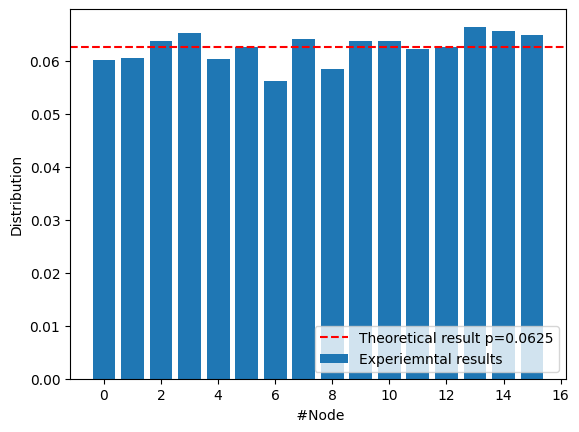

In [22]:
state_array = np.array ([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]) #Node array
result_array = np.array([481,484,509,522,482,501,449,513,467,509,510,498,501,531,525,518]) #Results of the experiment

plt.bar(state_array, result_array/8000,label ="Experiemntal results")
plt.axhline(y=0.0625, color='r', linestyle='--',label ="Theoretical result p=0.0625")

plt.xlabel(" #Node")
plt.ylabel("Distribution")

plt.legend(loc='lower right')

We can observe that the probability of finding the walker in one or another node is almost the same for each node. If we would want a more accurate result, the more shots for the experiment are done, the better would be the results.

Regarding the structure of the circuit, the circuit has a width of 25 qubits (4 qubits for representing the nodes as states , 4 representing the adjacent nodes, again as states and the rest being auxiliary qubits), and a depth of 2756 layers of operations, where at least the 99.5% of the layers are alocated at the W_operation, the function in charge of preparing the statements and implementing the diffuzzer.

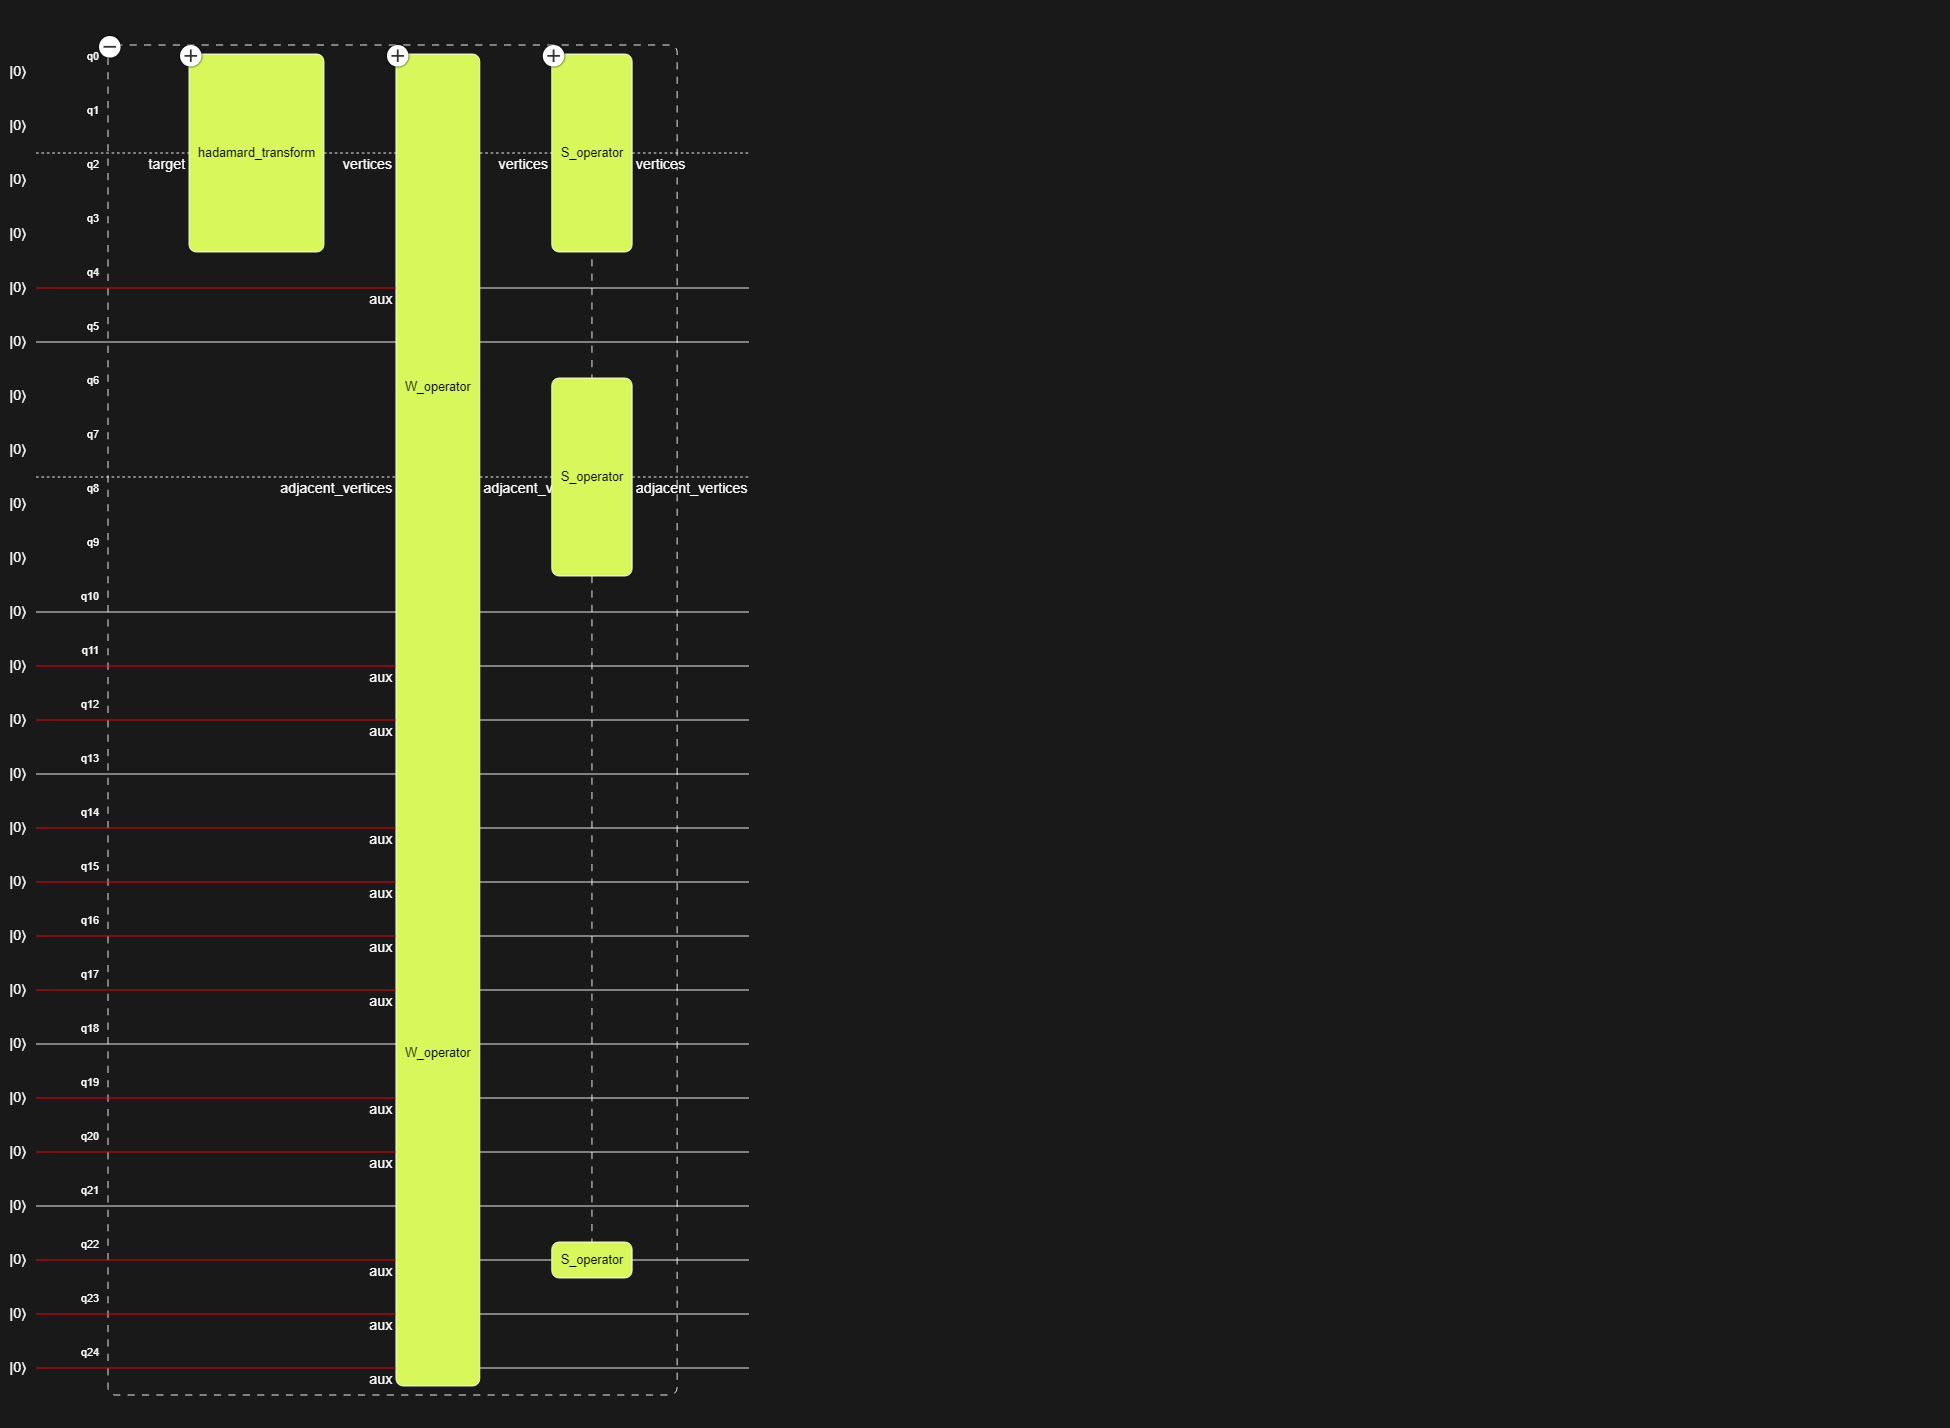

Preview of a slice of operation W

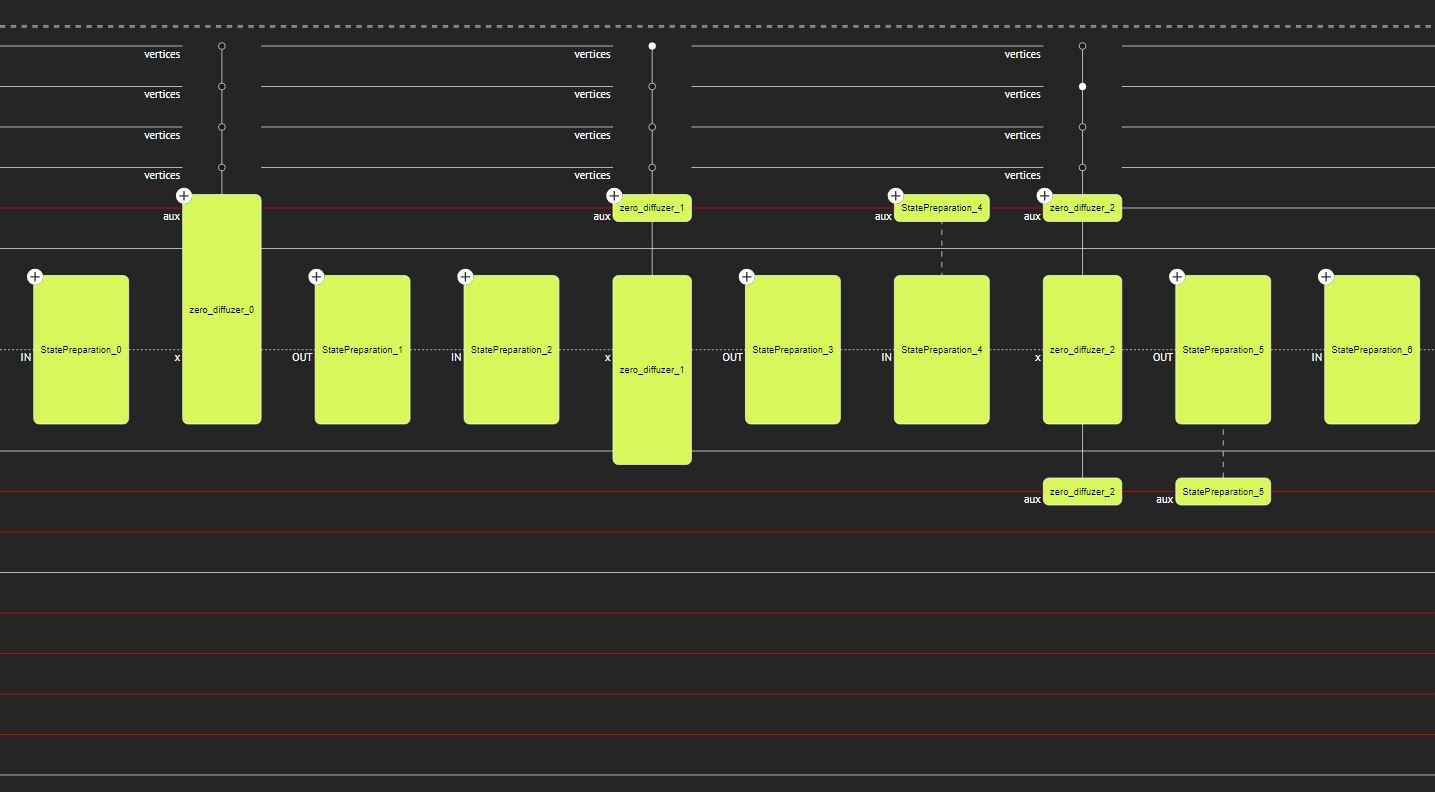

The S operator has a simpler structure in comparison with the W operator.

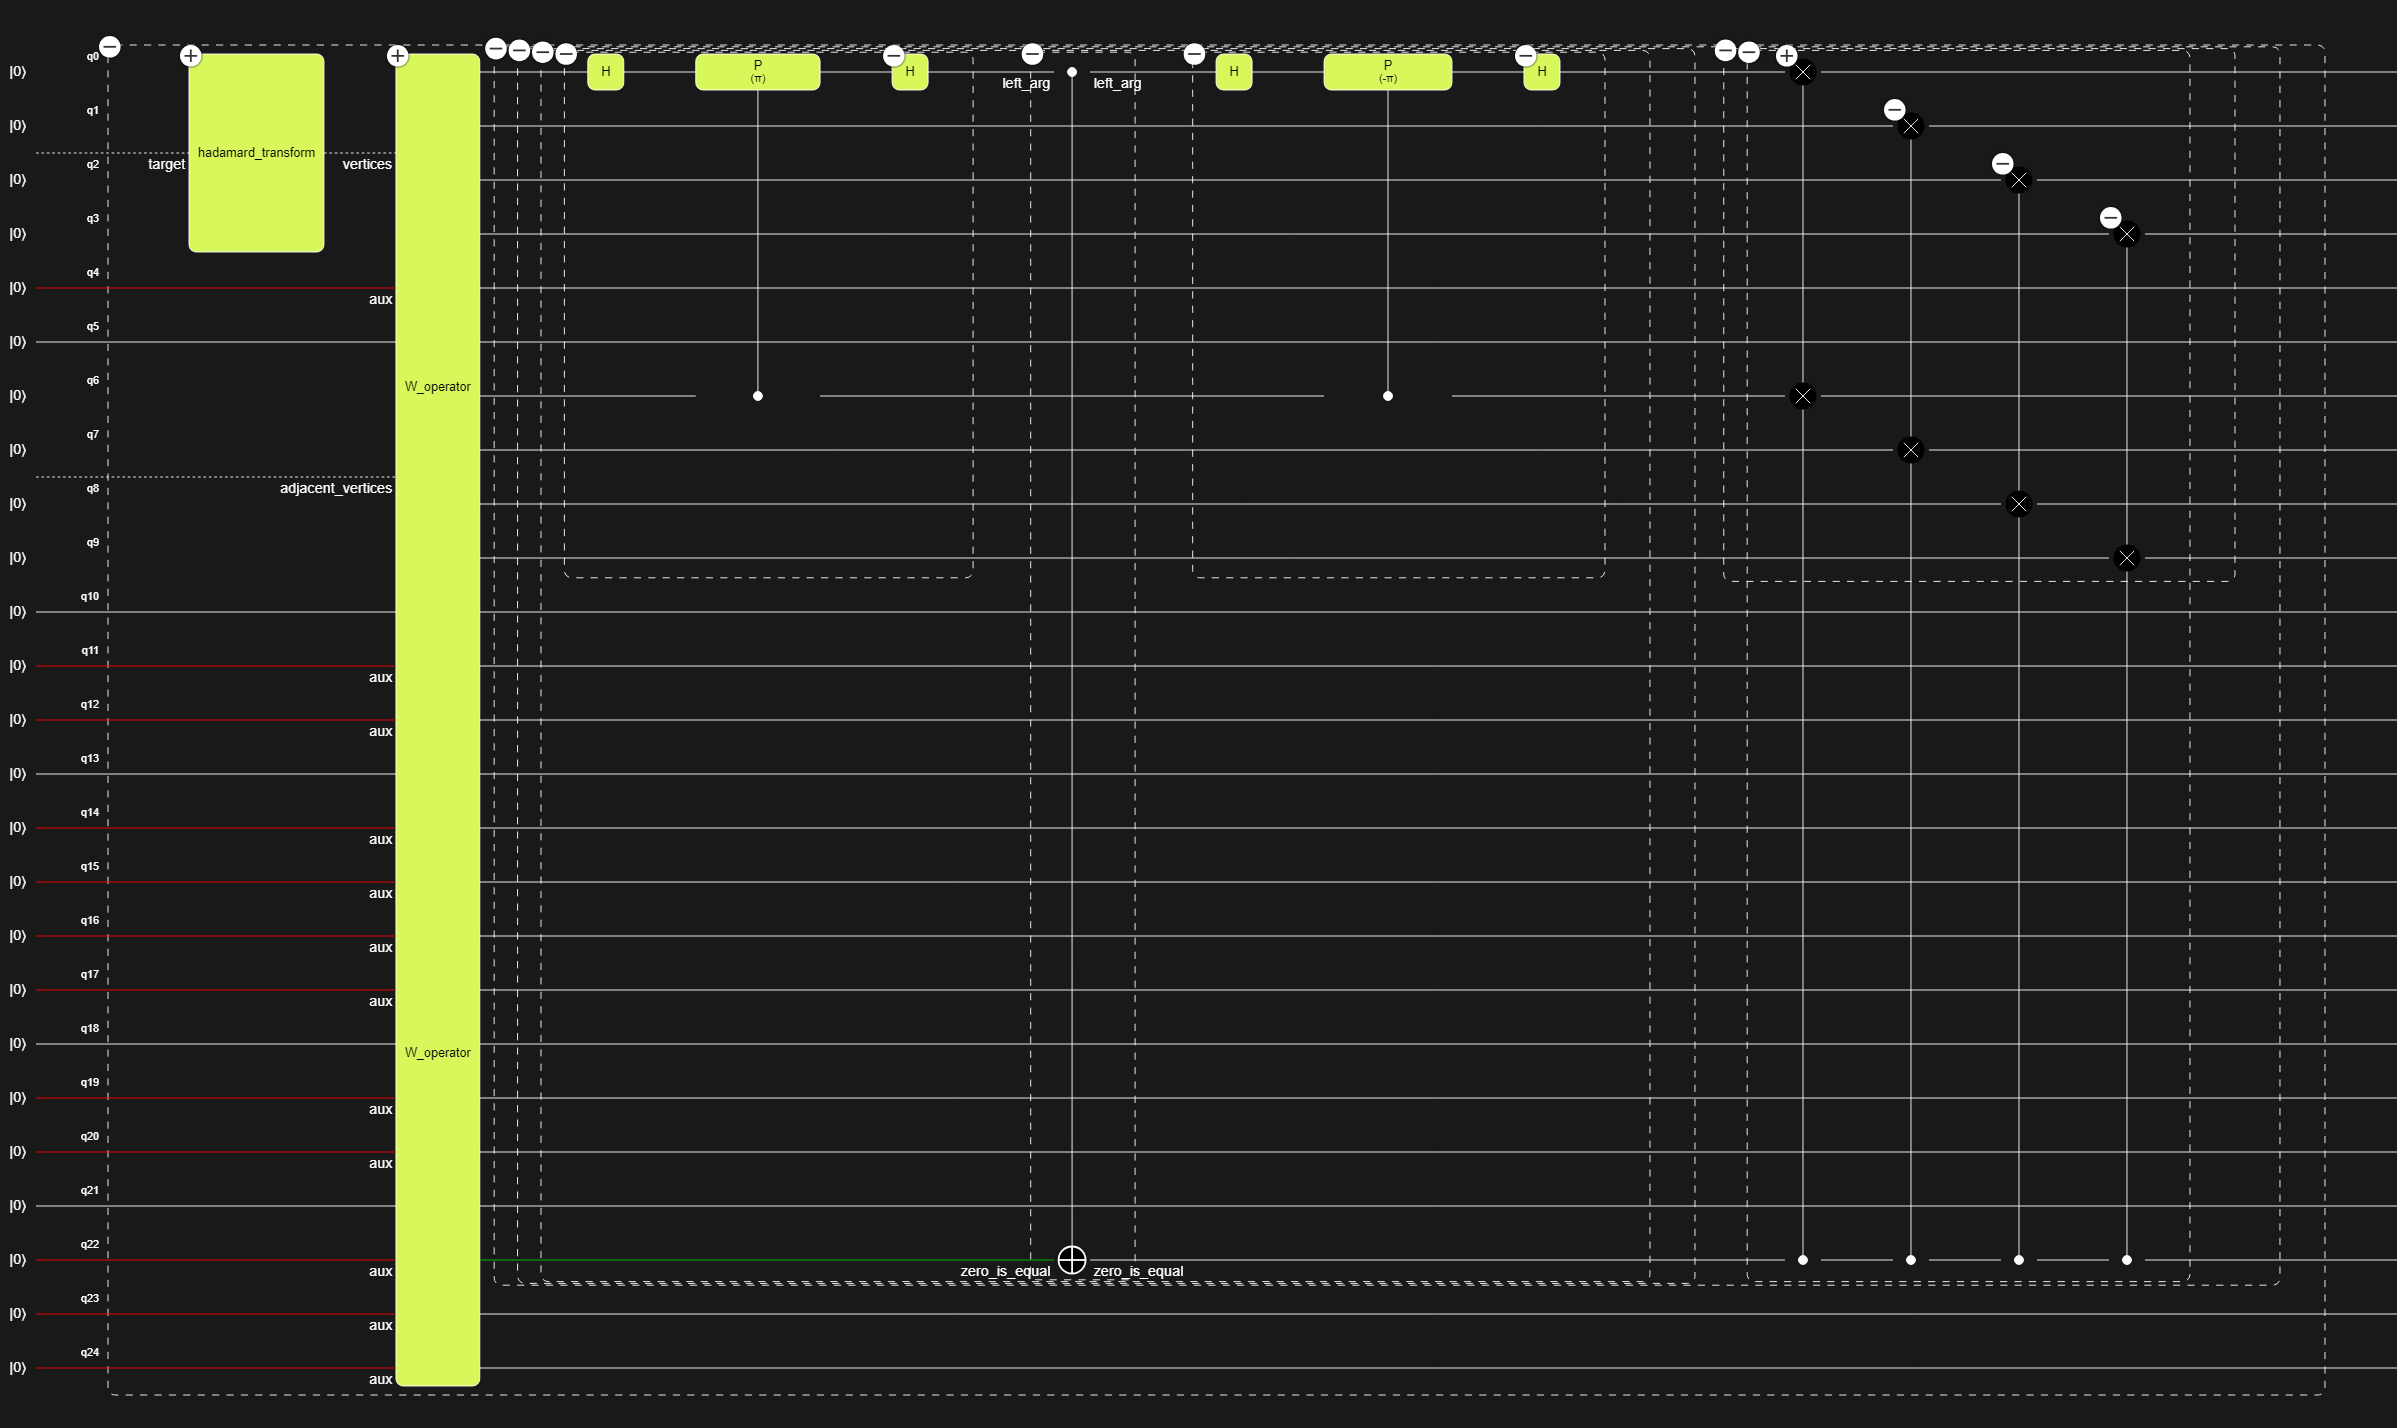

### Conclusion

It has been possible to design a circuit using python and the Classiq library to represent a desired chain of nodes to apply a random walk, but in the same way, it could have been designed to apply an Ising model in 1D or even extrapolate to a two-dimensional grid of nodes. Moreover, thanks to the classiq platform, it has been possible to simulate the circuit and demonstrate that it behaves like a real quantum walk.

Needless to say the power of the Classiq tool, which can quickly design quantum circuits from instructions given in python.